## This code create an LSTM model

In [17]:
import os
import wfdb
import numpy as np
import pandas as pd
import ast
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import welch
print(os.path.exists("../data/records500"))



True


In [13]:
def get_label(scp_codes):
    if "AFIB" in scp_codes:
        return 1
    if "NORM" in scp_codes:
        return 0
    if "ASMI" in scp_codes:
        return 2
    if "ALMI" in scp_codes:
        return 3
    if "NDT" in scp_codes:
        return 4
    if "NST_" in scp_codes:
        return 5
    if "CLBBB" in scp_codes:
        return 6
    if "IRBBB" in scp_codes:
        return 7
    if "IPLMI" in scp_codes:
        return 8
    return None




def load_ptbxl_metadata(dataset_root):
    df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))

    meta = {}
    for _, row in df.iterrows():
        scp_codes = ast.literal_eval(row["scp_codes"])
        
        label = get_label(scp_codes)
        if label is None:
            continue

        # NORMALIZE PATH (important!)
        key = row["filename_hr"].replace("\\", "/")

        meta[key] = {
            "ecg_id": int(row["ecg_id"]),
            "patient_id": int(row["patient_id"]),
            "label": label,
        }

    return meta


In [18]:
def scan_records500(dataset_root, meta):
    records500_root = os.path.join(dataset_root, "records500")

    records = []
    skipped = 0

    for subdir in sorted(os.listdir(records500_root)):
        subdir_path = os.path.join(records500_root, subdir)
        if not os.path.isdir(subdir_path):
            continue

        for fname in os.listdir(subdir_path):
            if not fname.endswith(".hea"):
                continue

            stem = fname[:-4]  # remove .hea

            # FORCE FORWARD SLASHES
            key = f"records500/{subdir}/{stem}"

            if key not in meta:
                skipped += 1
                continue

            info = meta[key]

            records.append({
                "hea_path": os.path.join(subdir_path, fname),
                "dat_path": os.path.join(subdir_path, stem + ".dat"),
                "label": info["label"],
                "patient_id": info["patient_id"],
                "ecg_id": info["ecg_id"],
            })
            
    
   
    print(f"Total 500 Hz records loaded: {len(records)}")
    print(f"Records skipped (no metadata): {skipped}")
    


    return records

def ecg_read(patient_id):
    record = wfdb.rdrecord(patient_id) 
    ecg_signal = record.p_signal[:,0]  
    fs = record.fs
    return ecg_signal, fs


Total 500 Hz records loaded: 16308
Records skipped (no metadata): 5529
exaple record: {'hea_path': '../data/records500\\00000\\00001_hr.hea', 'dat_path': '../data/records500\\00000\\00001_hr.dat', 'label': 0, 'patient_id': 15709, 'ecg_id': 1}
AFIB records  : 1514
NORM records  : 9491
ASMI records: 1995
ALMI records: 113
NDT records: 1615
NST_ records: 474
CLBBB records: 438
IRBBB records: 623
IPLMI records: 45


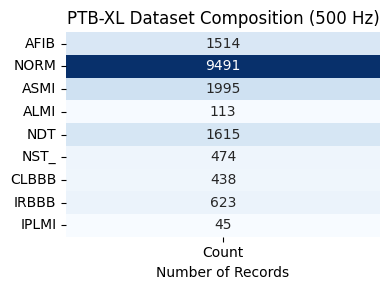

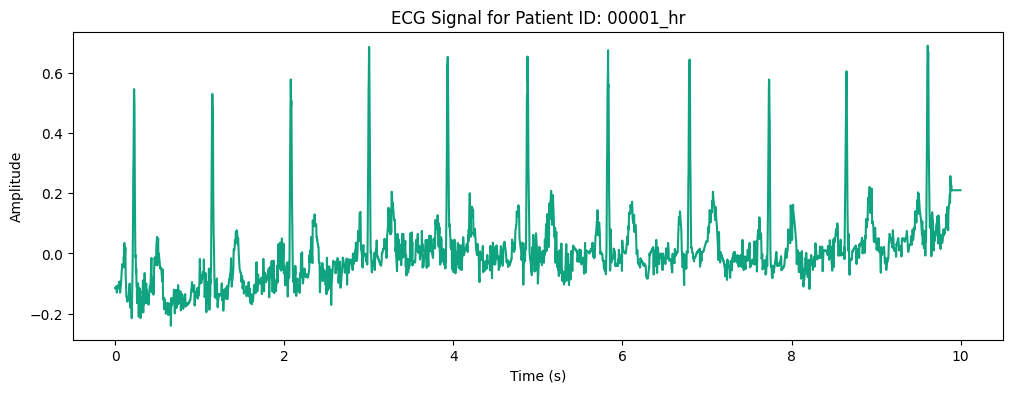

In [22]:
dataset_root = "../data/"

meta = load_ptbxl_metadata(dataset_root)
records = scan_records500(dataset_root, meta)
afib_records = [r for r in records if r["label"] == 1]
norm_records = [r for r in records if r["label"] == 0]
asmi_records = [r for r in records if r["label"] == 2]
almi_records = [r for r in records if r["label"] == 3]
ndt_records = [r for r in records if r["label"] == 4]
nst_records = [r for r in records if r["label"] == 5]
clbbb_records = [r for r in records if r["label"] == 6]
irbbb_records = [r for r in records if r["label"] == 7]
iplmi_records = [r for r in records if r["label"] == 8]

print("exaple record:", records[0])

print(f"AFIB records  : {len(afib_records)}")
print(f"NORM records  : {len(norm_records)}")
print(f"ASMI records: {len(asmi_records)}")
print(f"ALMI records: {len(almi_records)}")
print(f"NDT records: {len(ndt_records)}")
print(f"NST_ records: {len(nst_records)}")
print(f"CLBBB records: {len(clbbb_records)}")
print(f"IRBBB records: {len(irbbb_records)}")
print(f"IPLMI records: {len(iplmi_records)}")
composition_df = pd.DataFrame({
    "Class": ["AFIB", "NORM", "ASMI", "ALMI", "NDT", "NST_", "CLBBB", "IRBBB", "IPLMI"],
    "Count": [len(afib_records), len(norm_records), len(asmi_records), len(almi_records), len(ndt_records), len(nst_records), len(clbbb_records), len(irbbb_records), len(iplmi_records)]
    })

composition_df



plt.figure(figsize=(4, 3))

sns.heatmap(
    composition_df.set_index("Class"),
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("PTB-XL Dataset Composition (500 Hz)")
plt.ylabel("")
plt.xlabel("Number of Records")
plt.tight_layout()
plt.show()

id= '00001_hr'
ecg_signal, fs = ecg_read(id)   
time = np.arange(ecg_signal.shape[0]) / fs


# Plot the ECG signals
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, '#10a37f')
plt.title(f'ECG Signal for Patient ID: {id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()